# Исследование на выявление определяющих успешность игры закономерности.

Перед нами данные интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед нами данные до 2016 года. 2016 год не полный, не содержит данные за декабрь.

### Шаг. Откроем файл с данными и изучим общую информацию. 

In [ ]:
#импортируем библиотеку
#сохраним в переменную датафрейм, выведем информацию
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

data = pd.read_csv('/datasets/games.csv') 
data.info 

<bound method DataFrame.info of                                 Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

       

 Имеем датасет с 11 колонками и 16715 строк. видно, наглядно что имеются пропуски в колонках, названия колонок имеют заглавные буквы, года имеют не целые значения. 

### Шаг. Предобработка данных

In [ ]:
#Заменим названия столбцов (приведем к нижнему регистру)
data.columns = data.columns.str.lower()
data.columns            

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [ ]:
#изучим типы колонок
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Примечательно, что в столбце **year_of_release** год выпуска имеет не целое число, также с оценкой критиков в столбце **critic_score— оценка критиков** - значения с точкой,  а **user_score — оценка пользователей** должно быть числом, а имеет тип строки. Переведем столбцы в нужный тип данных. Но для начала изучим пропуски в столбцах.

In [ ]:
#изучим пропуски в датасете, опредилим их долю
data.isna().mean()*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

В столбцах  **name и genre** очень маленький процент пропусков, поэтому можно удалить эти строки, они не повлияют на наше исследование. В столбце **year_of_release** 1,6% не указано годов выпуска также маленький процент, заменим пустые значения на ноль. В **critic_score, user_score, rating** большой процент пропусков, в первом случае даже больше половины -51,3%, остальные  40%. 

In [ ]:
#заполним год выпуска значением 0
data['year_of_release'] = data['year_of_release'].fillna(0)

In [ ]:
#переведем в целочисленный тип столбец с годами
data['year_of_release'] = data['year_of_release'].astype('int32')
data['year_of_release']

0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16715, dtype: int32

In [ ]:
#удаление строк с пропуском в столбцах 'name', 'genre'
data = data.dropna(subset=['name', 'genre'], axis = 0)
data['name'].isna().sum()

0

In [ ]:
#проверим пропуски в столбце genre
data['genre'].isna().sum()

0

In [ ]:
#проверим значения genre на уникальность
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Жанры не имеют каких то аномалий, поэтому не нуждаются в дополнительном преобразовании.

In [ ]:
#изучим уникальные значения оценки пользователей
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Интересно, что среди чисел оценки есть оценка -'tbd'. Посмотрим какое количество значений с таким значением

In [ ]:
#посчитаем количество разных оценок клиента
data['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.7       2
1.5       2
1.9       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

**tbd** занимает по количеству оценок самое первое место и составляет больше всех значений -2424. To Be Determined, то есть "Будет определено". Очень часто подобное сокращение можно встретить в анонсах компьютерных игр в графе "Дата выхода". Когда разработчик той или иной игры уже сообщил о том, что она готовится к выходу, но пока еще не может назвать точную дату, именно это сокращение и используется. Этот вариант самый распространенный.

In [ ]:
#создадим отдельный столбец с tbd оценкой пользователей
pd.set_option('mode.chained_assignment', None)
data['user_score_tbd'] = data.loc[data['user_score'] == 'tbd', 'user_score']
data['user_score_tbd'] = data['user_score_tbd'].fillna('unknown')
data['user_score_tbd'].value_counts()

unknown    14289
tbd         2424
Name: user_score_tbd, dtype: int64

Вынесем в отдельный столбец игры,  ожидающие оценку со значением **tbd**.

In [ ]:
#заменим значения в user_score с tbd на ноль
data.loc[data['user_score'] == 'tbd', 'user_score'] =\
data.loc[data['user_score'] == 0, 'user_score']

In [ ]:
#заполним пропускив user_score нулевыми значениями
data['user_score'] = data['user_score'].fillna(0)

In [ ]:
#проверим столбец user_score на наличие пропусков
data['user_score'].isna().sum()

0

In [ ]:
#переведем столбец user_score в тип float64
data['user_score'] = data['user_score'].astype('float32')

Заменим значения tbd и пустые на ноль, т.к. мы их вынесли в другой столбец. Пропуски заполнили также на ноль,т.к. скорее всего это игры просто не имеющие оценок пользователей. Это необходимо, чтобы перевести столбец к типу float64, для удобства построения графиков и обработки данных.

In [ ]:
#изучим столбец critic_score на уникальные значения
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [ ]:
#заменим пустые значение critic_score на ноль
data['critic_score'] = data['critic_score'].fillna(0)

In [ ]:
#проверим пропуски в столбце critic_score
data['critic_score'].isna().sum()

0

In [ ]:
#переведем в целочисленный тип столбец critic_score
data['critic_score'] = data['critic_score'].astype('float32')
data['critic_score']

0        76.0
1         0.0
2        82.0
3        80.0
4         0.0
         ... 
16710     0.0
16711     0.0
16712     0.0
16713     0.0
16714     0.0
Name: critic_score, Length: 16713, dtype: float32

In [ ]:
#изучим столбец rating на уникальные значения
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [ ]:
#заменим пустые значение rating на unknown
data['rating'] = data['rating'].fillna('unknown')
data['rating'].value_counts()

unknown    6764
E          3990
T          2961
M          1563
E10+       1420
EC            8
RP            3
K-A           3
AO            1
Name: rating, dtype: int64

In [ ]:
#проверим пропуски в столбце rating
data['rating'].isna().sum()

0

In [ ]:
#изучим пропуски в датасете, опредилим их долю
data.isna().mean()*100

name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
critic_score       0.0
user_score         0.0
rating             0.0
user_score_tbd     0.0
dtype: float64

In [ ]:
#создадим столбец с суммой от продаж по всем регионам
data['all_sales_sum'] = data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
data['all_sales_sum']

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: all_sales_sum, Length: 16713, dtype: float64

In [ ]:
#проверим на наличие дубликатов датасет
data.duplicated().sum()

0

### Шаг. Проведем исследовательский анализ данных

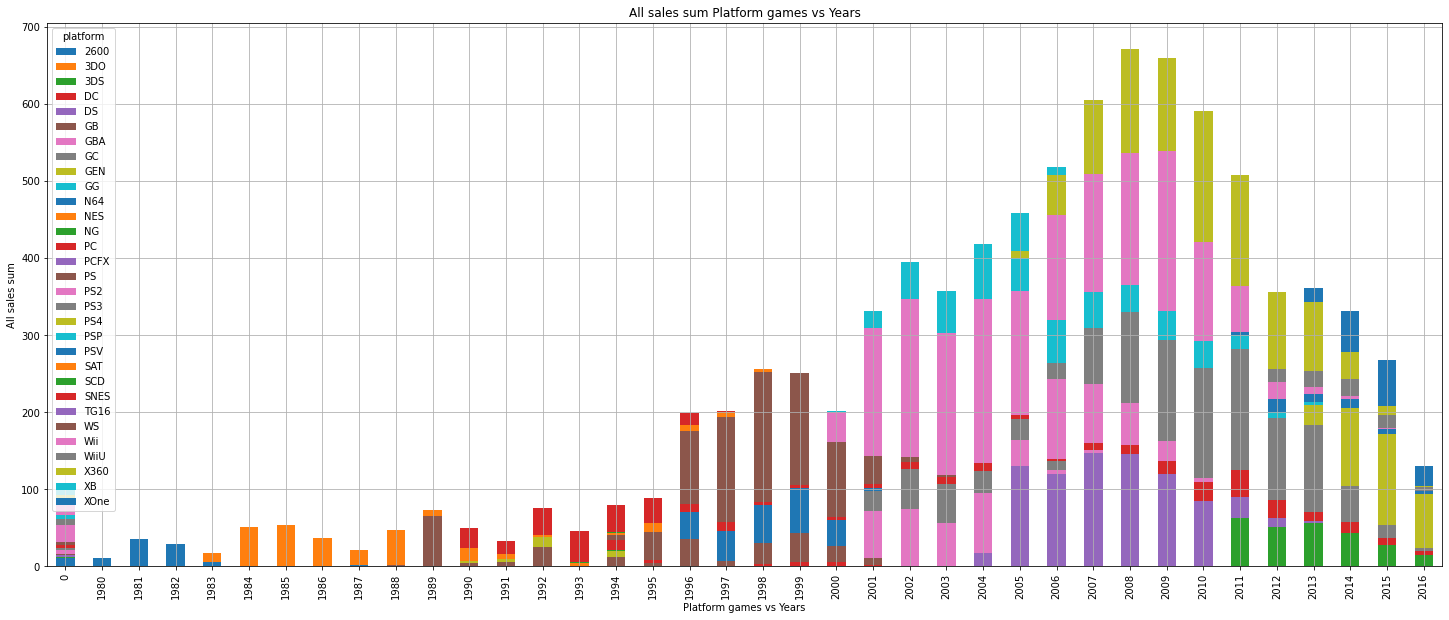

In [ ]:
#построим график по сводной таблице - зависимости суммы продаж платформ от года
data.groupby(['platform', 'year_of_release'])['all_sales_sum'].sum().unstack('platform')\
.plot(kind='bar', grid=True, figsize=(25, 10), stacked=True)
plt.title('All sales sum Platform games vs Years')
plt.ylabel('All sales sum')
plt.xlabel('Platform games vs Years')
plt.show()

In [ ]:
#сгруппируем данные по продажам платформ с увеличением по сумме продаж
#в таблице также число продаж и количество лет выпуска каждой платформы
data.groupby('platform').agg({'all_sales_sum':['sum'], 'year_of_release':['nunique','count']}).\
sort_values(by=('all_sales_sum',   'sum'), ascending=False)

all_sales_sum year_of_release      
                   sum         nunique count
platform                                    
PS2            1255.77              13  2161
X360            971.42              13  1262
PS3             939.65              12  1331
Wii             907.51              12  1320
DS              806.12              12  2151
PS              730.86              11  1197
GBA             317.85               9   822
PS4             314.14               4   392
PSP             294.05              13  1209
PC              259.52              27   974
3DS             259.00               7   520
XB              257.74              10   824
GB              255.46              14    98
NES             251.05              12    98
N64             218.68               8   319
SNES            200.04              10   239
GC              198.93               8   556
XOne            159.32               4   247
2600             96.98              11   133
WiiU             82.19               5   147
PSV              54.07               7   430
SAT              33.59               6   173
GEN              28.35               5    27
DC               15.95               7    52
SCD               1.86               2     6
NG                1.44               4    12
WS                1.42               3     6
TG16              0.16               1     2
3DO               0.10               2     3
GG                0.04               1     1
PCFX              0.03               1     1

По графику видно, что продажи увеличились вдвое и стали рости после 1996 года и до 2008года, затем пошли на снижение. Также до 1990 года было малое число различных платформ, где-то 1-2 шт. Также отметим, что среднее количество лет выпуска платформы 11-12 лет. Дольше всех выпускается платформа  PC - 27 лет. Достаточно высокие суммы продаж и одновременно высокое число продаж у первых 6 платформ.

In [ ]:
#сохраним в новый датасет данные с 2012 года
data_from_2012 = data.query('year_of_release >= 2012')

 За **актуальный период** выберем период за последние 5 лет от 2012 года по минимальной границе выбросов release_min_year_of_release, помним, что 2016 год не полный, там отсутствуют данные за декабрь. 

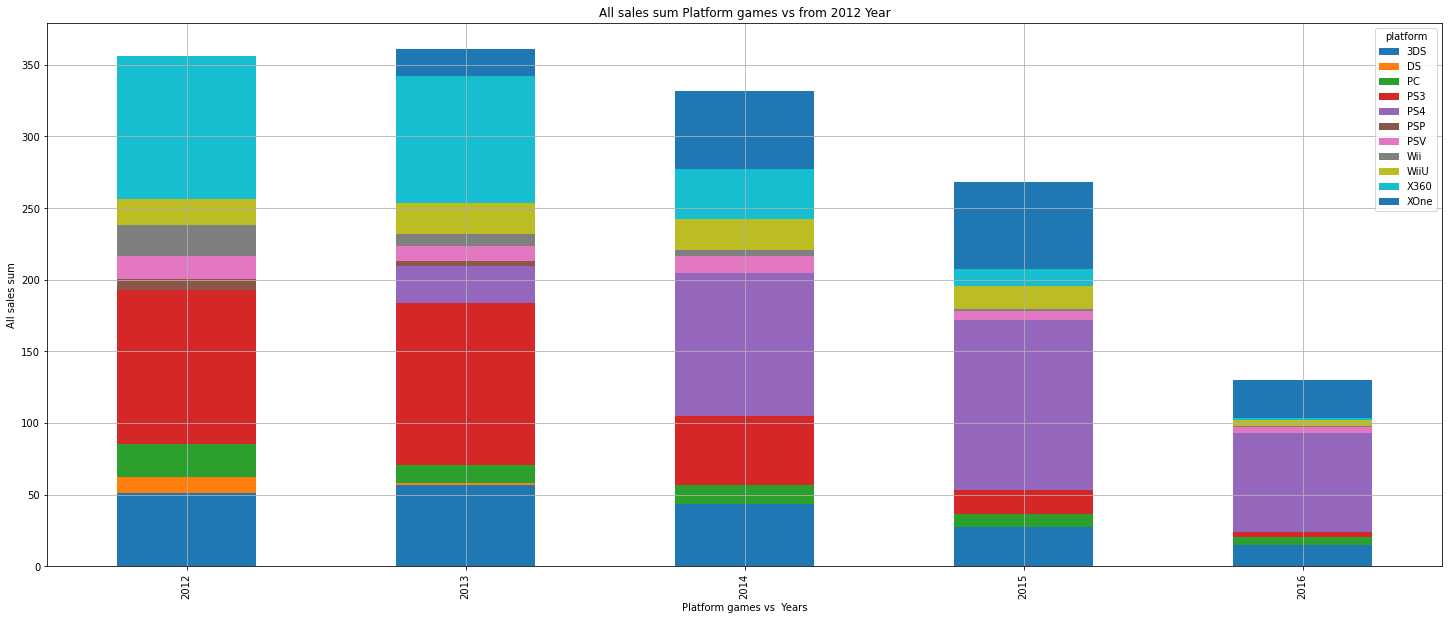

In [ ]:
#построим график по сводной таблице - зависимости суммы продаж платформ c 2012 года
data_from_2012.groupby(['platform', 'year_of_release'])['all_sales_sum'].sum().unstack('platform')\
.plot(kind='bar', grid=True, figsize=(25, 10), stacked=True)
plt.title('All sales sum Platform games vs from 2012 Year')
plt.ylabel('All sales sum')
plt.xlabel('Platform games vs  Years')
plt.show()

In [ ]:
#сводная таблица - зависимости суммы продаж платформ c 2012 года
pd.set_option('display.max_columns', None)
data_from_2012.groupby(['platform', 'year_of_release'])\
['all_sales_sum'].sum().unstack('platform')

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


За **актуальный период** выберем период с 2012 до 2016 год. Имеем ввиду, что 2016 год не полный, там отсутствуют данные за декабрь. По таблице и графику видно, что максимальные продажи к 2015 году имеют платформы PS4 и  XOne, у остальных значения упали в 2015 году, вероятно, что и в 2016 году не догонят уже значения предыдущего года. 
Также отметим, что эти две платформы появились в 2013 году. Помним, что средняя жизнь одной платформы около 10-12 лет, это значит, что и продажи **PS4 и  XOne** будут расти. 

Также интересна платформа **PC**, которая выпускается 27 лет и видно, что продажи по ней то высокие, тонзкие, то опять немного растут. Поэтому отметим и ее. Платформа **PSV**  значения не большие, но можно понаблюдать за ней.

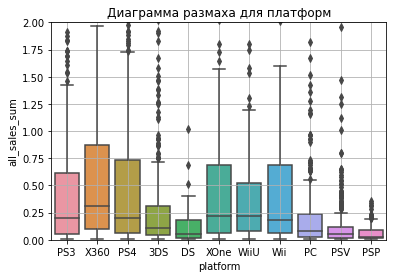

In [ ]:
#построим диаграмму размаха 
sns.boxplot(data=data_from_2012, y='all_sales_sum', x='platform')
plt.title('Диаграмма размаха для платформ')
plt.ylim(0, 2.0)
plt.grid(True)
plt.show()

 Из диаграмм размаха видно, что медианы и расстояние q1 -1.5*IQR у всех платформ смещены  влево, ближе к нулю, очень много выбросов вверх.

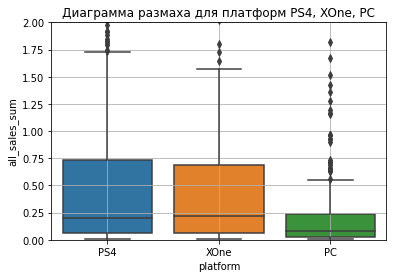

In [ ]:
#построим диаграмму размаха для "PS4", "XOne", "PC"
sns.boxplot(data= data_from_2012.query('platform == ["PS4", "XOne", "PC"]'),\
            y='all_sales_sum', x='platform')
plt.title('Диаграмма размаха для платформ PS4, XOne, PC')
plt.ylim(0, 2)
plt.grid(True)
plt.show()

 Рассмотрим подробно диаграммы размаха трех интересующих нас платформ **"PS4", "XOne", "PC"**. Отметим, что медианы и минимальная граница выбросов смещены влево, ближе к нулю. Рассстояние от третьего квартиля и макимальная граница выбросов имеют широкий диапазон. Медианы у платформ **PS4 и XOne имеют близкое положение, и сами диаграммы схожи. Когда как у платформы **PC** сама диаграмма мала и медиана около 10. 

In [ ]:
#выведем список характерных значений для платформ 
data_from_2012.groupby('platform')['all_sales_sum'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.0400,0.11,0.3125,14.60
DS,31.0,0.404839,1.439245,0.01,0.0200,0.05,0.1850,8.06
PC,250.0,0.250600,0.494640,0.01,0.0300,0.08,0.2400,5.14
PS3,493.0,0.585781,1.462855,0.01,0.0500,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.20,0.7300,14.63
PSP,173.0,0.064682,0.071296,0.01,0.0200,0.03,0.0900,0.36
PSV,411.0,0.119659,0.203011,0.01,0.0200,0.05,0.1200,1.96
Wii,54.0,0.655000,1.165447,0.01,0.0625,0.18,0.6875,6.76
WiiU,147.0,0.559116,1.058836,0.01,0.0800,0.22,0.5250,7.09


Рассмотрим для трех интересующих нас платформ **"PS4", "XOne", "PC"** диаграмму рассеивания и таблицы со списком характерных значений.

Видно, что у платформы **PC** медиана на значении 0,08, ср. значение 0,25, стандартное отклонение 0,49.

У платформы **PS4** медиана на значении 0,20, ср. значение 0,80, а вот стандартное отклонение 1,6.

У платформы **XOne** медиана на значении 0,31, ср. значение 0,81, а вот стандартное отклонение 1,7.

Интересно, что платформа **PSV** медиана на значении 0,05, ср. значение 0,12, стандартное отклонение 0,2, среди тех, которые еще выпускаются, это самое маленькое отклонение. Т.е. у **PSV** разброс величин отличается от среднего на 0,2.

Отметим, что у всех платформ минимальное значение 0,01, а медианы приблизительно одинаковы, по графику и таблице видно, что третий квартиль у всех разный.

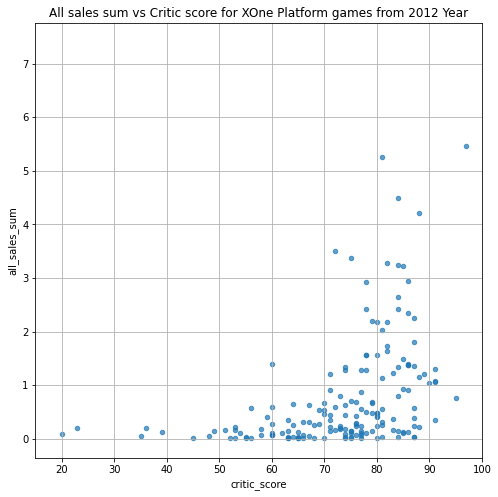

In [ ]:
#построим диаграмму рассеивания для XOne
data_from_2012.query("platform=='XOne'").\
plot(x='critic_score', y='all_sales_sum', kind='scatter', alpha=0.7,\
          grid=True, figsize=(8,8), xlim=(15,100))
plt.title('All sales sum vs Critic score for XOne Platform games from 2012 Year')
plt.show()

In [ ]:
#выведем значения корреляции сумм продаж от оценки критиков для платформы XOne
data_from_2012.query("platform=='XOne'")[['all_sales_sum', 'critic_score']].corr()

,all_sales_sum,critic_score
all_sales_sum,1.000000,0.274839
critic_score,0.274839,1.000000


Видно по диаграмме рассеивания для платформы **XOne** видно, что значения в основном находятся от 60 до 80 по оси оценки критиков, и до 1 по оси общей сумме продаж. По коэффициенту Пирсона, значение которого 0,27, можно сделать вывод, что значение далеко от 1. Поэтому с ростом одной величины, вторая растет, но не значительно.

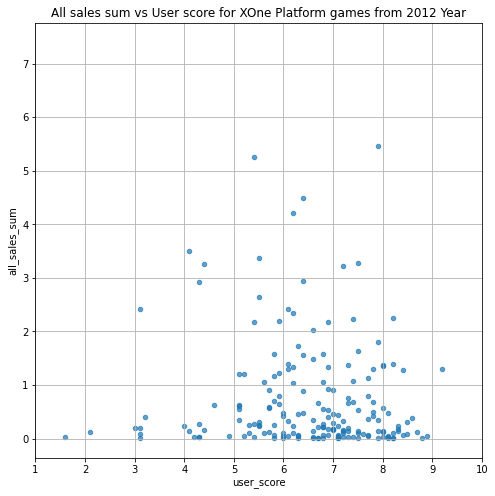

In [ ]:
#построим диаграмму рассеивания для XOne
data_from_2012.query("platform=='XOne'").\
plot(x='user_score', y='all_sales_sum', kind='scatter', alpha=0.7,\
          grid=True, figsize=(8,8), xlim=(1,10))
plt.title('All sales sum vs User score for XOne Platform games from 2012 Year')
plt.show()

In [ ]:
#выведем значения корреляции сумм продаж от оценки пользователей для платформы XOne
data_from_2012.query("platform=='XOne'")[['all_sales_sum', 'user_score']].corr()

,all_sales_sum,user_score
all_sales_sum,1.000000,0.116563
user_score,0.116563,1.000000


Видно по диаграмме рассеивания для платформы **XOne** видно, что значения в основном находятся от 6 до 8 по оси оценки пользователей, и до 1 по оси общей сумме продаж. По коэффициенту Пирсона, значение которого 0,12, можно сделать вывод, что значение далеко от 1. Поэтому с ростом одной величины, вторая почти не растет, т.к. значение близко к нулю.

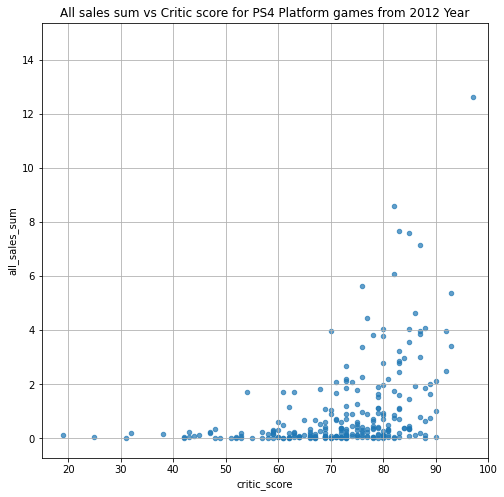

In [ ]:
#построим диаграмму рассеивания для PS4
data_from_2012.query("platform=='PS4'").\
plot(x='critic_score', y='all_sales_sum', kind='scatter', alpha=0.7,\
          grid=True, figsize=(8,8), xlim=(15,100))
plt.title('All sales sum vs Critic score for PS4 Platform games from 2012 Year')
plt.show()

In [ ]:
#выведем значения корреляции сумм продаж от оценки критиков для платформы PS4
data_from_2012.query("platform=='PS4'")[['all_sales_sum', 'critic_score']].corr()

,all_sales_sum,critic_score
all_sales_sum,1.00000,0.22755
critic_score,0.22755,1.00000


Видно по диаграмме рассеивания для платформы **PS4** видно, что значения в основном находятся от 60 до 80 по оси оценки критиков, и до 1 по оси общей сумме продаж. По коэффициенту Пирсона, значение которого 0,23, можно сделать вывод, что значение далеко от 1. Поэтому с ростом одной величины, вторая растет, но не значительно.

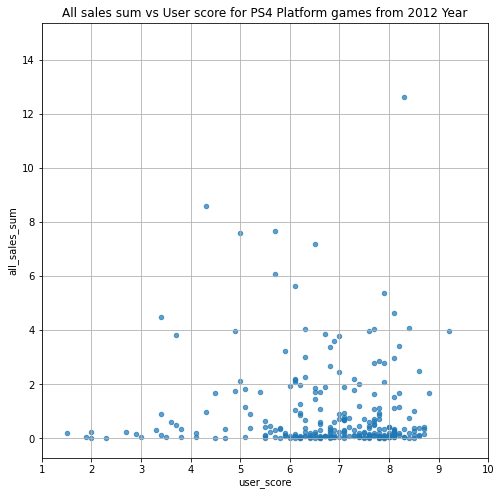

In [ ]:
#построим диаграмму рассеивания для PS4
data_from_2012.query("platform=='PS4'").\
plot(x='user_score', y='all_sales_sum', kind='scatter', alpha=0.7,\
          grid=True, figsize=(8,8), xlim=(1,10)) 
plt.title('All sales sum vs User score for PS4 Platform games from 2012 Year')
plt.show()

In [ ]:
#выведем значения корреляции сумм продаж от оценки пользователей для платформы PS4
data_from_2012.query("platform=='PS4'")[['all_sales_sum', 'user_score']].corr()

,all_sales_sum,user_score
all_sales_sum,1.000000,0.113116
user_score,0.113116,1.000000


Видно по диаграмме рассеивания для платформы **PS4** видно, что значения в основном находятся от 6 до 8 по оси оценки пользователей, и до 1 по оси общей сумме продаж, много около нуля. По коэффициенту Пирсона, значение которого 0,11, можно сделать вывод, что значение далеко от 1. Поэтому с ростом одной величины, вторая почти не растет, т.к. значение близко к нулю.

По анализу диаграмм двух перспективных платформ и коффицента коррляции сделаем вывод для всех остальных платформ, что оценка критиков незначительно влияет на увеличение продаж, а оценка пользователей еще меньше.  

In [ ]:
#выведем популярные жанры
data_from_2012['genre'].value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

По количеству продаж значительно выделяются **Action**.

In [ ]:
#выведем сводную таблицу продаваемых жанров
data_from_2012.pivot_table(index='genre', values='all_sales_sum').\
sort_values(by=('all_sales_sum'), ascending=False)

,all_sales_sum
genre,
Shooter,1.296723
Platform,0.717647
Sports,0.675634
Role-Playing,0.521081
Racing,0.465217
Misc,0.442917
Simulation,0.439000
Action,0.427856
Fighting,0.408165


По общей сумме продаж лидирует жанр **Shooter**, второе место занимает **Platform**, затем **Sports, Role-Playing, Racing** имеют приблизительно одинаковые продажи, остальные ниже.

### Шаг  Составьте портрет пользователя каждого региона

In [ ]:
#выведем первые 5 лидирующих платформ по продажам в Северной Америке
five_platform_na = data_from_2012.groupby('platform')[['na_sales']].sum().\
sort_values(by=('na_sales'), ascending=False).head()
five_platform_na

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


In [ ]:
#создадим столбец включающий 5 лидирующих платформ и другие в Северной Америке
data_from_2012['five_platform_na'] = data_from_2012['platform'].\
where(data_from_2012['platform'].isin(five_platform_na.index), 'Others')
data_from_2012['five_platform_na'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'Others', 'XOne'], dtype=object)

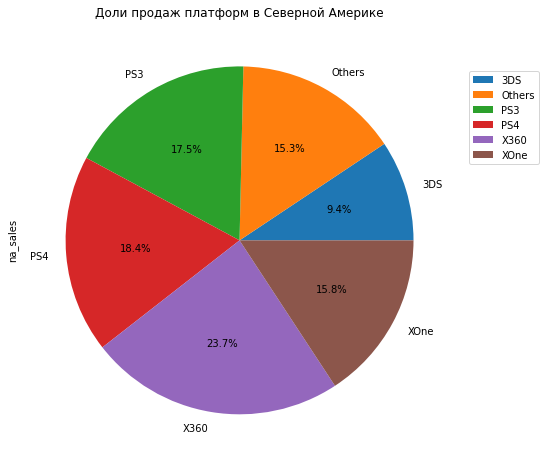

In [ ]:
#выведем график долей платформ по продажам в Северной Америке
data_from_2012.groupby('five_platform_na')[['na_sales']].sum().\
plot(title='Доли продаж платформ в Северной Америке', kind='pie',\
     y='na_sales', figsize=(12,8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0.3, 0.6, 0.6))
plt.show()

В Северной Америке 5 самых продаваемых платформ являются **X360, PS4, PS3, XOne, 3DS** по убыванию.

От общей доли продаж **X360** имеет 23.7%, **PS4** - 18.4%, **PS3, XOne, 3DS** - 17.5%, 15.8% и 9.4% соответственно. Доля продаж всех остальных платформ 15.3% 

In [ ]:
#выведем первые 5 лидирующих платформ по продажам в Европе
five_platform_eu = data_from_2012.groupby('platform')[['eu_sales']].sum().\
sort_values(by=('eu_sales'), ascending=False).head()
five_platform_eu

,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64


In [ ]:
#создадим столбец включающий 5 лидирующих платформ и другие в Европе
data_from_2012['five_platform_eu'] = data_from_2012['platform'].\
where(data_from_2012['platform'].isin(five_platform_eu.index), 'Others')
data_from_2012['five_platform_eu'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'Others', 'XOne'], dtype=object)

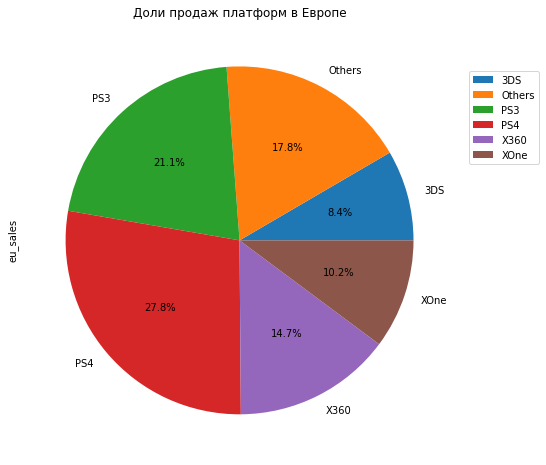

In [ ]:
#выведем график долей платформ по продажам в Европе
data_from_2012.groupby('five_platform_eu')[['eu_sales']].sum().\
plot(title='Доли продаж платформ в Европе', kind='pie',\
     y='eu_sales', figsize=(12,8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0.3, 0.6, 0.6))
plt.show()

В Европе 5 самых продаваемых платформ  являются **PS4, PS3, X360, XOne, 3DS** по убыванию. **PS4**  преобладает по продажам и большого преобладания по продажам по сравнению среди остальных нет.

От общей доли продаж **PS4** имеет 27.8%, **PS3** - 21.1%, **X360, XOne, 3DS** - 14.7%, 10.2% и 8.4% соответственно. Доля продаж всех остальных платформ 17.8% 

In [ ]:
#выведем первые 5 лидирующих платформ по продажам в Японии
five_platform_jp = data_from_2012.groupby('platform')[['jp_sales']].sum().\
sort_values(by=('jp_sales'), ascending=False).head()
five_platform_jp

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


In [ ]:
#создадим столбец включающий 5 лидирующих платформ и другие в Японии
data_from_2012['five_platform_jp'] = data_from_2012['platform'].\
where(data_from_2012['platform'].isin(five_platform_jp.index), 'Others')
data_from_2012['five_platform_jp'].unique()

array(['PS3', 'Others', 'PS4', '3DS', 'WiiU', 'PSV'], dtype=object)

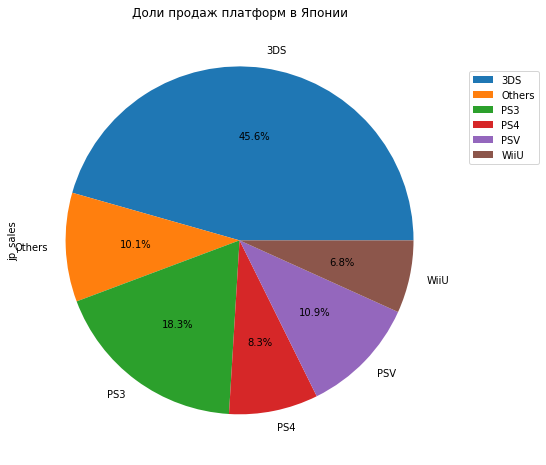

In [ ]:
#выведем график долей платформ по продажам в Японии
data_from_2012.groupby('five_platform_jp')[['jp_sales']].sum().\
                                    plot(title='Доли продаж платформ в Японии', kind='pie',\
     y='jp_sales', figsize=(12,8), autopct='%1.1f%%') 
plt.legend(bbox_to_anchor=(0.6, 0.3, 0.6, 0.6))
plt.show()

В Японии 5 самых продаваемых платформ являются **3DS, PS3, PSV, PS4, WiiU** по убыванию. **3DS**  имеет наибольшее преобладание по продажам по сравнению с остальными. Остальные приблизительно в одном диапазоне.

От общей доли продаж **3DS** имеет 45.6%, **PS3** - 18.3%, **PSV, PS4, WiiU** - 10.9%, 8.3% и 6.8% соответственно. Доля продаж всех остальных платформ 10.1%.

Так же отметим, что самая популярная платформа в Японии **3DS**, занимает 5 место в Европе и Северной Америке. 

In [ ]:
#выведем пять популярных жанров игр в Северной Америке
data_from_2012.groupby('genre')[['na_sales']].sum().\
sort_values(by=('na_sales'), ascending=False).head()

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


Пять популярных жанров игр в Северной Америке - **Action, Shooter, Sports, Role-Playing, Misc**. Лидирующие значения у **Action, Shooter** составляют 177,84 и 144,77, остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

In [ ]:
#выведем пять популярных жанров игр в Европе
data_from_2012.groupby('genre')[['eu_sales']].sum().\
sort_values(by=('eu_sales'), ascending=False).head()

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29


Пять популярных жанров игр в Европе - **Action, Shooter, Sports, Role-Playing, Racing**. Лидирующие значения у **Action, Shooter** составляют 159,34 и 113,47,  остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

In [ ]:
#выведем пять популярных жанров игр в Японии
data_from_2012.groupby('genre')[['jp_sales']].sum().\
sort_values(by=('jp_sales'), ascending=False).head()

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


Пять популярных жанров игр в Японии - **Role-Playing, Action, Misc,  Simulation, Fighting**. Лидирующие значения у **Role-Playing** составляют 65,44, **Action** - 52,80, остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

Отметим, что в Европе и Северной Америке поппулярные платформы **Action, Shooter**, а в Японии **Role-Playing, Action**.

In [ ]:
#выведем продажи 5 самых продаваемых рейтингов в Северной Америке
data_from_2012.groupby('rating')[['na_sales']].sum().\
sort_values(by=('na_sales'), ascending=False).head()

,na_sales
rating,
M,231.57
E,114.37
unknown,103.31
E10+,75.70
T,66.02


Пять популярных рейтингов игр в Северной Америке - **M, E, unknown, E10+, T**. Лидирующие значения у **M** составляют 231,57, **E** - 114,37, **unknown** - 103,37,  остальные имеют меньше продаж.

In [ ]:
#выведем продажи 5 самых продаваемых рейтингов в Европе
data_from_2012.groupby('rating')[['eu_sales']].sum().\
sort_values(by=('eu_sales'), ascending=False).head()

,eu_sales
rating,
M,193.96
E,113.03
unknown,91.50
E10+,55.37
T,52.96


Пять популярных рейтингов игр в Европе те же  - **M, E, unknown, E10+, T**. Лидирующие значения у **M** составляют 193,96, **E** - 113,03,  **unknown** - 91,50, остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

In [ ]:
#выведем продажи 5 самых продаваемых рейтингов в Японии
data_from_2012.groupby('rating')[['jp_sales']].sum().\
sort_values(by=('jp_sales'), ascending=False).head()

,jp_sales
rating,
unknown,108.84
E,28.33
T,26.02
M,21.20
E10+,8.19


Пять популярных рейтингов игр в Японии  - **unknown, E, T, M, E10+**. Лидирующие значения у игр не имеющих рейтинг **unknown** составляют 108,84, **E** -28,33, **T** -26,02 остальные имеют меньше продаж. 

Отметим, что популярная платформа в Японии **unknown**, занимает 3 место в Европе и Северной Америке.

### Шаг. Проверьте гипотезы

In [ ]:
#Проверим Hо гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые
XOne = data_from_2012[data_from_2012['platform'] =='XOne']['user_score']
PC = data_from_2012[data_from_2012['platform'] =='PC']['user_score']

print('Средние пользовательские оценки XOne:', XOne.mean())
print('Средние пользовательские оценки PC:', PC.mean())

results = st.ttest_ind(
    XOne,
    PC,
    equal_var=False
)
   

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средние пользовательские оценки XOne: 4.805263
Средние пользовательские оценки PC: 5.2972
0.06811017214972821
Не получилось отвергнуть нулевую гипотезу


**Hо гипотеза** - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**H1 гипотеза** - средние пользовательские рейтинги платформ Xbox One и PC разные.

Видим, что Средние пользовательские оценки **XOne: 4.81**, а Средние пользовательские оценки **PC: 5.30**, вероятность получить наблюдаемый результат **pvalue = 0.068** это больше порогового значения **alpha =0.05**. Поэтому не получилось отвергнуть нулевую гипотезу

In [ ]:
#Выберем за Hо гипотезу - Средние пользовательские рейтинги жанров Action и Sports одинаковые.
action = data_from_2012[data_from_2012['genre'] =='Action']['user_score']
sports = data_from_2012[data_from_2012['genre'] =='Sports']['user_score']

print('Среднее пользовательских рейтингов Action:', action.mean())
print('Среднее пользовательских рейтингов Sports:', sports.mean())

results = st.ttest_ind(
    action,
    sports,
    equal_var=False
)
   

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среднее пользовательских рейтингов Action: 3.4621727
Среднее пользовательских рейтингов Sports: 3.9697762
0.01416698849151676
Отвергаем нулевую гипотезу


Выберем за **Hо гипотезу** - Средние пользовательские рейтинги жанров Action и Sports одинаковые.

 **H1 гипотеза** - Средние пользовательские рейтинги жанров Action и Sports разные.

Видим, что Среднее пользовательских рейтингов **Action: 3.46**, а Среднее пользовательских рейтингов **Sports: 3.97**, они не равны. Вероятность получить наблюдаемый результат **pvalue = 0.014** меньше порогового значения **alpha =0.05**. Поэтому Отвергаем нулевую гипотезу.


### Шаг. Общий вывод

Были изученны данные интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Задача выявить определяющие успешность игры закономерности. Чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед нами данные были до 2016 года. 2016 год не полный, не содержит данные за декабрь.

Данные в столбцах **critic_score, user_score, rating** имели большой процент пропусков, в первом случае даже больше половины -51,3%, остальные  40%. Не все платормы были оценены критиками и пользователями.

За **актуальный период** выберем период с 2012 до 2016 год. Имеем ввиду, что 2016 год не полный, там отсутствуют данные за декабрь. По таблице и графику видно, что максимальные продажи к 2015 году имеют платформы PS4 и  XOne, у остальных значения упали в 2015 году, вероятно, что и в 2016 году не догонят уже значения предыдущего года. 
Также отметим, что эти две платформы появились в 2013 году. Помним, что средняя жизнь одной платформы около 10-12 лет, это значит, что и продажи **PS4 и  XOne** будут расти. 

Также интересна платформа **PC**, которая выпускается 27 лет и видно, что продажи по ней то высокие, тонзкие, то опять немного растут. Поэтому отметим и ее. Платформа **PSV**  значения не большие, но можно понаблюдать за ней.

По диаграммам размаха трех интересующих нас платформ **"PS4", "XOne", "PC"**. Отметили, что медианы и минимальная граница выбросов смещены влево, ближе к нулю. Рассстояние от третьего квартиля и макимальная граница выбросов имеют широкий диапазон. Медианы у платформ **PS4 и XOne** имеют близкое положение, и сами диаграммы схожи. Когда как у платформы **PC** сама диаграмма мала и медиана около 10.

Видно, что у платформы **PC** медиана на значении 0,08, ср. значение 0,25, стандартное отклонение 0,49.

У платформы **PS4** медиана на значении 0,20, ср. значение 0,80, а вот стандартное отклонение 1,6.

У платформы **XOne** медиана на значении 0,31, ср. значение 0,81, а вот стандартное отклонение 1,7.

Интересно, что платформа **PSV** медиана на значении 0,05, ср. значение 0,12, стандартное отклонение 0,2, среди тех, которые еще выпускаются, это самое маленькое отклонение. Т.е. у **PSV** разброс величин отличается от среднего на 0,2.

Отметим, что у всех платформ минимальное значение 0,01, а медианы приблизительно одинаковы, по графику и таблице видно, что третий квартиль у всех разный.

По анализу диаграмм двух перспективных платформ **PS4 и  XOne** и коффицента коррляции сделали вывод для всех остальных платформ, что оценка критиков незначительно влияет на увеличение продаж, а оценка пользователей еще меньше. Они обе ближе к нулю, чем к 1.  

По количеству общих продаж значительно выделяются жанры **Action**

По общей сумме продаж лидирует жанр **Shooter**, второе место занимает **Platform**, затем **Sports, Role-Playing, Racing** имеют приблизительно одинаковые продажи, остальные ниже.

В Северной Америке 5 самых продаваемых платформ являются **X360, PS4, PS3, XOne, 3DS** по убыванию.

От общей доли продаж в Северной Америке **X360** имеет 23.7%, **PS4** - 18.4%, **PS3, XOne, 3DS** - 17.5%, 15.8% и 9.4% соответственно. Доля продаж всех остальных платформ 15.3% 

В Европе 5 самых продаваемых платформ  являются **PS4, PS3, X360, XOne, 3DS** по убыванию. **PS4**  преобладает по продажам и большого преобладания по продажам по сравнению среди остальных нет.

От общей доли продаж в Европе **PS4** имеет 27.8%, **PS3** - 21.1%, **X360, XOne, 3DS** - 14.7%, 10.2% и 8.4% соответственно. Доля продаж всех остальных платформ 17.8% 

В Японии 5 самых продаваемых платформ являются **3DS, PS3, PSV, PS4, WiiU** по убыванию. **3DS**  имеет наибольшее преобладание по продажам по сравнению с остальными. Остальные приблизительно в одном диапазоне.

От общей доли продаж в Японии **3DS** имеет 45.6%, **PS3** - 18.3%, **PSV, PS4, WiiU** - 10.9%, 8.3% и 6.8% соответственно. Доля продаж всех остальных платформ 10.1%.

Так же отметим, что самая популярная платформа в Японии **3DS**, занимает 5 место в Европе и Северной Америке. 

Пять популярных жанров игр в Северной Америке - **Action, Shooter, Sports, Role-Playing, Misc**. Лидирующие значения у **Action, Shooter** составляют 177,84 и 144,77, остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

Пять популярных жанров игр в Европе - **Action, Shooter, Sports, Role-Playing, Racing**. Лидирующие значения у **Action, Shooter** составляют 159,34 и 113,47,  остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

Пять популярных жанров игр в Японии - **Role-Playing, Action, Misc,  Simulation, Fighting**. Лидирующие значения у **Role-Playing** составляют 65,44, **Action** - 52,80, остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

Отметим, что в Европе и Северной Америке поппулярные платформы **Action, Shooter**, а в Японии **Role-Playing, Action**.

Пять популярных рейтингов игр в Северной Америке - **M, E, unknown, E10+, T**. Лидирующие значения у **M** составляют 231,57, **E** - 114,37, **unknown** - 103,37,  остальные имеют меньше продаж.

Пять популярных рейтингов игр в Европе те же  - **M, E, unknown, E10+, T**. Лидирующие значения у **M** составляют 193,96, **E** - 113,03,  **unknown** - 91,50, остальные имеют меньше продаж и  приблизительно находятся в одном диапазоне.

Пять популярных рейтингов игр в Японии  - **unknown, E, T, M, E10+**. Лидирующие значения у игр не имеющих рейтинг **unknown** составляют 108,84, **E** -28,33, **T** -26,02 остальные имеют меньше продаж. 

Отметим, что популярная платформа в Японии **unknown**, занимает 3 место в Европе и Северной Америке.

Средние пользовательские рейтинги платформ **Xbox One и PC одинаковые**.
Средние пользовательские рейтинги жанров **Action и Sports разные**.